# M5 Walmart Sales Forcasting competition
### Validation Set WRMSSE for Statistical Benchmarks

[M5 Participants Guide](https://mofc.unic.ac.cy/m5-competition/)

This notebook enables the following:
1. Selecting validation sets with arbitrary start date and number of days.
2. Scoring these validation sets with "Weight Root Mean Squared Scaled Error" WRMSSE (as described in M5 Participants Guide).
3. Implementing and testing Statistical Benchmarks #1 - #5.

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Load inputs into orig_* dataframes
orig_* dataframes should remain unchanged.

- ~60 seconds initial setup time
- Involves loading csvs into dataframes (10 seconds) and creating Daily Sales Volume dataframe (50 seconds)
- This only needs to run once.

In [ ]:
with open('/kaggle/input/m5-forecasting-accuracy/sell_prices.csv') as f:
    orig_sell_prices_df = pd.read_csv(f)
print("%0.2f GB" % (orig_sell_prices_df.memory_usage().sum() / 2**30))

In [ ]:
with open('/kaggle/input/m5-forecasting-accuracy/calendar.csv') as f:
    orig_calendar_df = pd.read_csv(f)
print("%0.4f GB" % (orig_calendar_df.memory_usage().sum() / 2**30))

In [ ]:
with open('/kaggle/input/m5-forecasting-accuracy/sales_train_validation.csv') as f:
    orig_sales_df = pd.read_csv(f)
print("%0.2f GB" % (orig_sales_df.memory_usage().sum() / 2**30))

In [ ]:
with open('/kaggle/input/m5-forecasting-accuracy/sample_submission.csv') as f:
    orig_sample_sub_df = pd.read_csv(f, index_col='id')
print("%0.2f GB" % (orig_sample_sub_df.memory_usage().sum() / 2**30))

# Create Daily Volume dataframe

volume = sell_price_daily * orig_sales_df

*sell_prices.csv* provides **weekly prices**, but we need **daily prices**

In [ ]:
# Convert Weekly sell price data to daily price data, matching the column format of orig_sales_df
def get_daily_sell_price():
    sell_price_df = orig_sell_prices_df[['wm_yr_wk', 'sell_price']].copy()
    sell_price_df.set_index(pd.Index(orig_sell_prices_df['item_id'] + '_' + orig_sell_prices_df['store_id'] + '_validation', name='id'), inplace=True)
    daily_price_df = sell_price_df.join(orig_calendar_df.set_index('wm_yr_wk').d, on='wm_yr_wk')
    # pivot_table() takes up to 50 seconds and lots of memory
    res = daily_price_df.pivot_table(values='sell_price', index='id', columns='d')
    sorted_columns = sorted(list(res.columns),key=lambda x: len(x))
    return res[sorted_columns]

def get_daily_sales_vol():
    sales_vol_df = orig_sales_df.set_index('id')
    extra_cols = ['store_id', 'item_id','dept_id','cat_id','state_id']
    saved_descriptive_columns = sales_vol_df[extra_cols].copy()
    daily_sell_price = get_daily_sell_price()
    sales_vol_df *= daily_sell_price
    sales_vol_df[extra_cols] = saved_descriptive_columns
    return sales_vol_df.reset_index()

# NaN's represent days for which no id price was provided
orig_vol_df = get_daily_sales_vol()
orig_vol_df.head(10)


# Create Training and Validation set
| LAST_DAY_TRAINING_SET | Validation Set Days | Validation Set Columns |
|------|------|----|
| d_1913 | None | None |
| d_1912 | {d_1913} | {F1} |
| d_1911 | {d_1912, d_1913} | {F1, F2} |
| d_1910 | {d_1911, d_1912, d_1913} | {F1, F2, F3} |
| ... | ... | ... | ... |
| d_1885 | {d_1886, d_1887, ..., d_1913} | {F1, F2, ..., F28} |
| d_1884 | {d_1885, d_1886, ..., d_1912} | {F1, F2, ..., F28} |
| d_1883 | {d_1884, d_1885, ..., d_1911} | {F1, F2, ..., F28} |

when MAX_VALIDATION_DAYS = 28

In [ ]:
# Change this to anything < d_1913 to generate validation set
LAST_DAY_TRAINING_SET = 'd_1885'
GENERATE_SUBMISSION_CSV = False
MAX_VALIDATION_DAYS = 28

"""
When GENERATE_SUBMISSION_CSV == True and LAST_DAY_TRAINING_SET == d_1913:
    submission.csv for Public LB is created
    Private LB submissions are currently not handled.
"""

def get_df_up_to_column(df, col):
    col_idx = df.columns.tolist().index(col)
    return df.iloc[:,slice(col_idx+1)].copy()

def get_validation_df(last_train_day):
    valid_start_idx = orig_sales_df.columns.tolist().index(last_train_day) + 1
    valid_df = None
    num_valid_days = min([len(orig_sales_df.columns) - valid_start_idx, MAX_VALIDATION_DAYS])
    if num_valid_days > 0:
        valid_df =  orig_sales_df.iloc[:,slice(valid_start_idx, valid_start_idx+num_valid_days)]
        valid_df.columns = ['F' + str(i) for i in range(1,num_valid_days+1)]
        valid_df.index = orig_sales_df.id.values
    return valid_df

def get_predictions_df(validation_df):
    if validation_df is None or MAX_VALIDATION_DAYS == 0:
        return orig_sample_sub_df.copy()
    num_pred_cols = min([len(validation_df.columns), MAX_VALIDATION_DAYS])
    res = orig_sample_sub_df.copy()
    col_max = len(res.columns)
    if num_pred_cols > col_max:
        for col_idx in range(col_max, num_pred_cols+1):
            res['F' + str(col_idx)] = 0
    return res.iloc[:,slice(num_pred_cols)]

def set_last_training_day(last_train_day):
    sales_df = get_df_up_to_column(orig_sales_df, last_train_day)
    vol_df = get_df_up_to_column(orig_vol_df, last_train_day)
    valid_df = get_validation_df(last_train_day) # None if last_train_day = d_1913
    predictions_df = get_predictions_df(valid_df)

    return sales_df, vol_df, valid_df, predictions_df

price_df = orig_sell_prices_df.copy()
cal_df = orig_calendar_df.copy()
sales_df, vol_df, valid_df, predictions_df = set_last_training_day(LAST_DAY_TRAINING_SET)
sales_df.head(10)

## Remove ids that have 0 sales in training period
If LAST_DAY_TRAINING_SET <= d_1845, at least 1 id will have zero sales in training dataset.

These rows are removed from all df's to simplify the scoring process.

In [ ]:
d_cols = [col for col in sales_df.columns if 'd_' in col]
total_sales_df = sales_df.set_index('id')[d_cols].sum(axis=1)
zero_sales_idx = total_sales_df[total_sales_df == 0].index
if len(zero_sales_idx) > 0:
    sales_df = sales_df.set_index('id').drop(zero_sales_idx).reset_index()
    vol_df = vol_df.set_index('id').drop(zero_sales_idx).reset_index()
    valid_df = valid_df.drop(zero_sales_idx)
    predictions_df = predictions_df.drop(zero_sales_idx)

print('Removed ' + str(len(zero_sales_idx)) + ' rows with zero sales.')

# Validation Set values (valid_df)

In [ ]:
from IPython.display import display

if valid_df is not None:
    display(valid_df.head())
else:
    print('No validation set has been created. Make sure that (LAST_DAY_TRAINING_SET < d_1913) to generate.')

# Precompute RMSSE Denominators and WRMSSE Volume Weights 

### RMSSE Calculation:
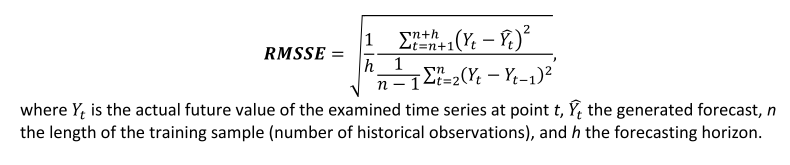
The Denominator of this equation is only dependent on the values of the training set, so it can be precomputed for faster iteration.

### Volume-based weights (from Competitors Guide):

> "The forecasting errors computed for each participating method (both RMSSE and SPL) will be weighted across the M5 series based on their **cumulative actual dollar sales**, which is a good and objective proxy of their actual value for the company in monetary terms. The cumulative dollar sales will be computed using the **last 28 observations** of the training sample (sum of units sold multiplied by their respective price), i.e., a period equal to the forecasting horizon. Note that since both the number of units being sold and their respective price change through time, this estimation is based on the sum of the corresponding daily dollar sales."

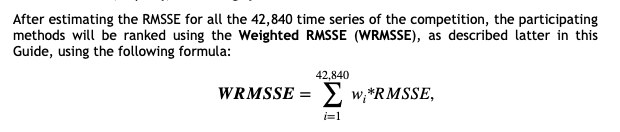

Side Note for items with zero sales at beginning of time series:

> "Note that the denominator of RMSSE is computed only for the time-periods for which the examined product(s) are actively sold, i.e., the periods following the first non-zero demand observed for the series under evaluation."

In [ ]:
LAST_N_DAYS_USED_FOR_WEIGHTING_RMSSE = 28 # from M5 Competitors Guide
NUM_AGGREGATION_LEVELS = 12 # from M5 Competitors Guide
def get_vol_based_weights(vol_df, gb):
    # Aggregate at level gb
    res = vol_df.groupby(gb).sum()
    # Only use last N days according to guide
    res = res[res.columns[-LAST_N_DAYS_USED_FOR_WEIGHTING_RMSSE:]].sum(axis=1)
    # Turn sales volume into % of aggregation level
    res /= res.sum()
    # Each aggregation level counts evenly (1/NUM_AGGREGATION_LEVELS) towards final score 
    res /= NUM_AGGREGATION_LEVELS
    res.name = 'Weight'
    return res.reset_index()

def get_rmsse_denominators(unit_sales_df, gb):
    d_cols = [col for col in unit_sales_df.columns if 'd_' in col]
    # Aggregate at level gb
    agg_sales = unit_sales_df.groupby(gb).sum(min_count=1)[d_cols]
    # (Y(t) - Y(t-1))
    res = agg_sales - agg_sales.shift(1,axis=1)
    # (Y(t) - Y(t-1)) ** 2
    res = res ** 2
    # (1 / (N-1)) * SUM((Y(t) - Y(t-1)) ** 2)
    res = (1 / (agg_sales.notna().sum(axis=1) -1)) * res.sum(axis=1)
    res.name = 'rmsse_denom'
    return res.reset_index()

def get_rmsse_numerators(error_df, gb):
    # Get h, the # of day columns 
    # Should be 28 unless validation set contains fewer days.
    num_pred_days = sum(['F' == col[0] for col in error_df.columns])
    # Aggregate at level gb
    error_agg = error_df.groupby(gb).sum()
    # (1 / h) * Sum(Y(t) - Y^(t))
    res = (1 / num_pred_days) * (error_agg ** 2).sum(axis=1)
    res.name = 'rmsse_numerator'
    return res.reset_index()

# Applies func to each level of gb_cols
# Returns DataFrame of combined results
def apply_heirarchy_ts(df, func):
    all_rows = pd.Index([True]*len(df), name='all_rows')
    gb_cols = [all_rows,   # Level 1
               'state_id', # Level 2
               'store_id', # Level 3
               'cat_id',   # Level 4
               'dept_id',  # Level 5
               ['state_id', 'cat_id'],  # Level 6
               ['state_id', 'dept_id'], # Level 7
               ['store_id', 'cat_id'],  # Level 8
               ['store_id', 'dept_id'], # Level 9
               'item_id',               # Level 10
               ['item_id', 'state_id'], # Level 11
               ['item_id', 'store_id']] # Level 12

    idx_cols = ['all_rows','state_id','store_id','cat_id','dept_id','item_id']
    return pd.concat([func(df, gb) for gb in gb_cols], sort=True).set_index(idx_cols)



## From M5 Competitors Guide
| Level id | Aggregation Level   | Number of Series  |
|------|------|----|
| 1 | Unit sales of all products, aggregated for all stores/states | 1 |
| 2 | Unit sales of all products, aggregated for each State | 3 |
| 3 | Unit sales of all products, aggregated for each store  | 10 |
| 4 | Unit sales of all products, aggregated for each category | 3 |
| 5 | Unit sales of all products, aggregated for each department | 7 |
| 6 | Unit sales of all products, aggregated for each State and category | 9 |
| 7 | Unit sales of all products, aggregated for each State and department | 21 |
| 8 | Unit sales of all products, aggregated for each store and category | 30 |
| 9 | Unit sales of all products, aggregated for each store and department | 70 |
| 10 | Unit sales of product x, aggregated for all stores/states | 3,049 |
| 11 | Unit sales of product x, aggregated for each State | 9,147 |
| 12 | Unit sales of product x, aggregated for each store | 30,490 |
| Total | - | 42,840 |

In [ ]:
wrmsse_weights = apply_heirarchy_ts(vol_df, get_vol_based_weights)


In [ ]:
"""" Note that the denominator of RMSSE is computed only for the time-periods
     for which the examined product(s) are actively sold, i.e., the periods 
     following the first non-zero demand observed for the series under evaluation.
"""
rmsse_contribution = sales_df.notna()
rmsse_contribution[d_cols] = sales_df[d_cols].replace(0, np.nan).ffill(axis=1).notna()

rmsse_denom = apply_heirarchy_ts(sales_df[rmsse_contribution], get_rmsse_denominators)


In [ ]:
import datetime as dt

def get_rmsse_df(actual, predictions):
    pred_error = sales_df[['state_id','store_id','cat_id','dept_id','item_id', 'id']].join(actual - predictions, on='id')
    rmsse_numerator = apply_heirarchy_ts(pred_error, get_rmsse_numerators)
    rmsse_df = wrmsse_weights.join(rmsse_denom)
    return rmsse_df.join(rmsse_numerator)

def score_wrmsse(actual, predictions):
    rmsse_final = get_rmsse_df(actual, predictions)
    # w(i) * sqrt((RMSSE_NUM / RMSSE_DENOM))
    rmsse_final['wrmsse_contribution'] = rmsse_final['Weight'] * ((rmsse_final['rmsse_numerator'] / rmsse_final['rmsse_denom']) ** .5)
    return rmsse_final, rmsse_final['wrmsse_contribution'].sum()

def predict_wrmsse(preds):
    if GENERATE_SUBMISSION_CSV:
        print('Generating submission.csv.')
        with open('submission_' + dt.datetime.now().strftime("%Y%m%d-%H%M%S") + '.csv', 'w') as f:
            preds.to_csv(f)

    if valid_df is None:
        return None, None
    return score_wrmsse(valid_df, preds)


In [ ]:
# Time Series df
ts_df = sales_df.set_index('id').copy()
# Mask for time series data points that are actually used in RMSSE computation
ts_days_counted_msk = ts_df[d_cols].replace(0, np.nan).ffill(axis=1).notna()

# Statistical Benchmarks

## 1) Naive

| WRMSSE | Training Set | Validation Set |
|------|------|----|
| 1.46378 | d_1 - d_1913 | **(Public LB)** d_1914 - d_1941 |
| 1.4862651683366184 | d_1 - d_1885 | d_1886 - d_1913 |
| 1.6850237352357273 | d_1 - d_1400 | d_1401 - d_1500 |

In [ ]:
def get_most_recent_ts_predictions():
    preds_df = predictions_df.copy()
    preds_df.loc[ts_df.index,:] = ts_df.iloc[:,[-1]].values
    return preds_df

## 2) sNaive

| WRMSSE | Training Set | Validation Set |
|------|------|----|
| 0.86967 | d_1 - d_1913 | **(Public LB)** d_1914 - d_1941 |
| 0.92262 | d_1 - d_1885 | d_1886 - d_1913 |
| 1.24013 | d_1 - d_1400 | d_1401 - d_1500 |

Use last week of sales as prediction for future weeks.

In [ ]:
def get_pred_last_week():
    preds_df = predictions_df.copy()
    last_week_sales = ts_df.iloc[:,slice(-7,len(ts_df.columns))]
    preds_df.loc[ts_df.index] = [list(w) * (len(preds_df.columns) // 7) + list(w[:(len(preds_df.columns) % 7)]) for w in last_week_sales.values]
    return preds_df


## 3) Simple Exponential Smoothing (alpha=.1)

| WRMSSE | Training Set | Validation Set |
|------|------|----|
| 1.06912 | d_1 - d_1913 | **(Public LB)** d_1914 - d_1941 |
| 1.11068 | d_1 - d_1885 | d_1886 - d_1913 |
| 1.19542 | d_1 - d_1400 | d_1401 - d_1500 |

In [ ]:
# Exponential Smoothing Helper Functions
def smooth(x, alpha, res):
    if x.name == 0:
        return x
    res[x.name] = x*alpha + res[x.name - 1].fillna(x)*(1-alpha)

def get_exp_smoothed_df(df, alpha, smooth_func):
    res = df.copy()
    res.columns = list(range(len(df.columns)))
    func = lambda x: smooth_func(x, alpha, res)
    res.apply(func)
    res.columns = df.columns
    return res


In [ ]:
def get_simple_exp_smoothing(alpha):
    preds_df = predictions_df.copy()
    smoothed_df = get_exp_smoothed_df(ts_df[ts_days_counted_msk].loc[:,d_cols], alpha, smooth)
    preds_df.loc[ts_df.index,:] = [list(i)*len(preds_df.columns) for i in smoothed_df.iloc[:,[-1]].values]
    return preds_df


## 4) Moving Average

| WRMSSE | Training Set | Validation Set |
|------|------|----|
| 1.10694 | d_1 - d_1913 | **(Public LB)** d_1914 - d_1941 |
| 1.17943 | d_1 - d_1885 | d_1886 - d_1913 |
| 1.39181 | d_1 - d_1400 | d_1401 - d_1500 |

In [ ]:
# Helper function
def get_min_mse_rolling_window(df, rolling_window_options):
    min_mse = None
    window_res = None
    for option in rolling_window_options:
        sq_error = (df.rolling(option, axis=1).mean().shift(axis=1) - df) ** 2
        total_mse = sq_error.mean(axis=1).sum()
        if min_mse is None or total_mse < min_mse:
            min_mse = total_mse
            window_res = option
    return window_res

In [ ]:
def get_simple_moving_avg_predictions(rolling_window=None):
    preds_df = predictions_df.copy()
    min_mse = None
    if rolling_window is None:
        rolling_window = get_min_mse_rolling_window(ts_df[ts_days_counted_msk].loc[:,d_cols], [2,3,4,5])
    preds_df.loc[ts_df.index,:] = [[i]*len(preds_df.columns) for i in ts_df.iloc[:,slice(-rolling_window,len(ts_df.columns))].mean(axis=1).tolist()]
    return preds_df


## 5) Croston (alpha = .1)

| WRMSSE | Training Set | Validation Set |
|------|------|----|
| 1.05648 | d_1 - d_1913 | **(Public LB)** d_1914 - d_1941 |
| 1.13238 | d_1 - d_1885 | d_1886 - d_1913 |
| 1.26183 | d_1 - d_1400 | d_1401 - d_1500 |

In [ ]:
# Helper Functions
def smooth_croston(x, alpha, res):
    if x.name == 0:
        return x
    df = res[x.name - 1].copy()
    df[res[x.name] > 0] = x*alpha + res[x.name - 1].fillna(x)*(1-alpha)
    res[x.name] = df

def applyNumDays(x, df):
    if x.name == 0:
        return x
    df[x.name] = (df[x.name] * (df[x.name-1] + 1)).fillna(df[x.name])
    return df[x.name]

def get_num_days_since_last_sale(df):
    msk_df = df.copy()
    msk_df += 1
    msk_df[msk_df > 1] = 0
    msk_df.columns = list(range(len(msk_df.columns)))
    num_days_func = lambda x: applyNumDays(x, msk_df)
    msk_df = msk_df.apply(num_days_func).shift(axis=1)
    msk_df.columns = df.columns
    return msk_df

In [ ]:
def get_crost_method(alpha):
    preds_df = predictions_df.copy()
    msk_df = ts_df[ts_days_counted_msk].loc[:,d_cols]
    num_days = get_num_days_since_last_sale(msk_df) + 1
    num_days = num_days.fillna(1)[ts_days_counted_msk]
    num_days[msk_df == 0] = 0
    num_days = get_exp_smoothed_df(num_days, alpha, smooth_croston)
    smoothed_df = get_exp_smoothed_df(msk_df, alpha, smooth_croston)
    smoothed_df /= num_days
    preds_df.loc[ts_df.index,:] = [list(i)*len(preds_df.columns) for i in smoothed_df.iloc[:,[-1]].values]
    return preds_df


# Execute Chosen Prediction Method

In [ ]:
preds = get_pred_last_week()
wrmsse_df, wrmsse = predict_wrmsse(preds)
if wrmsse is not None:
    print('WRMSSE:', wrmsse)
    display(wrmsse_df.head(10))
